# Toy example

Let"s generate some data and compare our HMM implementation with the one from the hmmlearn library as an additional method to test the implementation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from hmmlearn.hmm import CategoricalHMM
import hmm as hmm

In [3]:
np.random.seed(42)

## Data generation

In [4]:
def generate_observations(num_obs, pi, T, E):
    def drawFrom(probs):
        return np.where(np.random.multinomial(1,probs) == 1)[0][0]

    obs = np.zeros(num_obs)
    states = np.zeros(num_obs)
    
    states[0] = drawFrom(pi)
    obs[0] = drawFrom(E[:, int(states[0])])

    for t in range(1,num_obs):
        states[t] = drawFrom(T[int(states[t-1]),:])
        obs[t] = drawFrom(E[:, int(states[t])])
    
    return np.int64(obs), states

In [5]:
true_pi = np.array([0.5, 0.5])

true_T = np.array([[0.85, 0.15],
                  [0.12, 0.88]])

true_E = np.array([[0.8, 0.0],
                   [0.1, 0.0],
                   [0.1, 1.0]])

In [6]:
obs_seq1, states1 = generate_observations(200, true_pi, true_T, true_E)
obs_seq2, states2 = generate_observations(160, true_pi, true_T, true_E)

states = np.concatenate((states1, states2))
obs_seq = np.concatenate((obs_seq1, obs_seq2))
lengths = np.array([len(obs_seq1), len(obs_seq2)])

In [7]:
print("First 10 Obersvations:  ", obs_seq1[:10])
print("First 10 Hidden States: ", states1[:10])

First 10 Obersvations:   [2 0 0 0 2 2 2 2 1 0]
First 10 Hidden States:  [1. 0. 0. 0. 1. 1. 1. 1. 0. 0.]


## Our HMM

In [8]:
init_pi = np.array([0.5, 0.5])

init_T = np.array([[0.5, 0.5],
                  [0.5, 0.5]])

init_E = np.array([[0.3, 0.2],
                   [0.3, 0.5],
                   [0.4, 0.3]]).T

l_init_pi = np.log(init_pi)
l_init_T = np.log(init_T)
l_init_E = np.log(init_E)

In [9]:
model = hmm.HMM(2, 3)

n_iter = 100

model.fit(obs_seq, lengths, n_iter, l_init_pi, l_init_T, l_init_E, convergence_eps=-1)

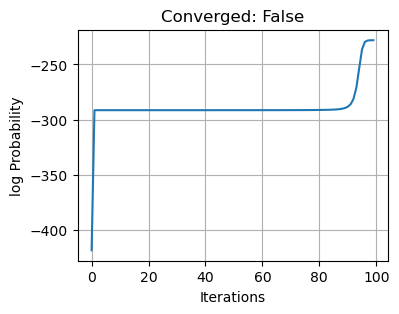

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(model._history)
ax.set_title(f"Converged: {len(model._history) < n_iter}")
ax.set_xlabel("Iterations")
ax.set_ylabel("log Probability")
ax.grid()

In [11]:
model.get_transition_matrix()

array([[0.84362808, 0.15637192],
       [0.12898729, 0.87101271]])

In [12]:
model.get_emission_matrix()

array([[7.82784957e-01, 1.02125839e-01, 1.15089203e-01],
       [1.66353141e-02, 1.37410230e-05, 9.83350945e-01]])

In [13]:
hidden_pred = model.predict(obs_seq)

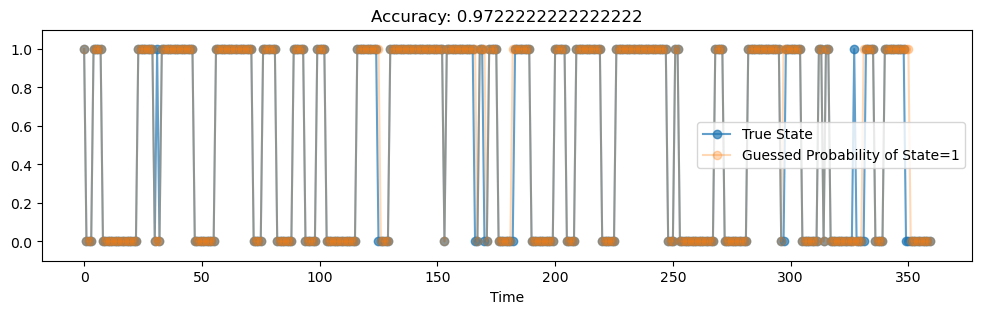

In [14]:
acc = np.mean(hidden_pred == states)

plt.figure(figsize=(12,3))
plt.plot(states.T,"-o",alpha=0.7)
plt.plot(hidden_pred, "-o",alpha=0.3)
plt.legend(("True State","Guessed Probability of State=1"), loc = "right")
plt.ylim(-0.1,1.1)
plt.xlabel("Time")
plt.title(f"Accuracy: {acc}")
plt.draw()

## Reference HMM

In [15]:
model = CategoricalHMM(n_components=2, n_iter=2000, tol=0.0001, random_state=3)
model.fit(obs_seq.reshape(-1,1))

CategoricalHMM(n_components=2, n_features=3, n_iter=2000,
               random_state=RandomState(MT19937) at 0x70BBF3A1AC40, tol=0.0001)

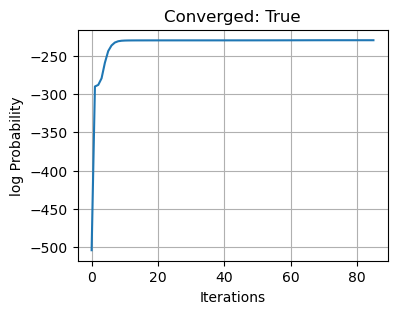

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(model.monitor_.history)
ax.set_title(f"Converged: {model.monitor_.converged}")
ax.set_xlabel("Iterations")
ax.set_ylabel("log Probability")
ax.grid()

In [17]:
model.transmat_

array([[0.84028216, 0.15971784],
       [0.12710791, 0.87289209]])

In [18]:
model.emissionprob_

array([[7.84775509e-01, 1.02159920e-01, 1.13064571e-01],
       [1.51962817e-02, 2.01927038e-52, 9.84803718e-01]])

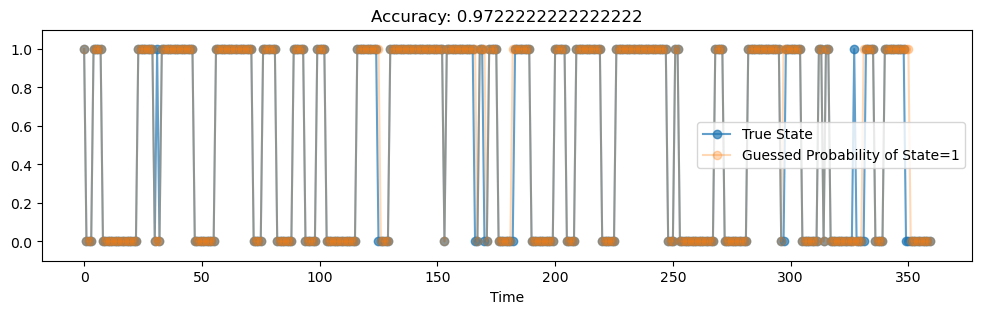

In [19]:
hidden_pred = model.predict(obs_seq.reshape(-1,1))

acc = np.mean(hidden_pred == states)

plt.figure(figsize=(12,3))
plt.plot(states.T,"-o", alpha=0.7)
plt.plot(hidden_pred, "-o", alpha=0.3)
plt.legend(("True State","Guessed Probability of State=1"), loc="right")
plt.ylim(-0.1,1.1)
plt.xlabel("Time")
plt.title(f"Accuracy: {acc}")
plt.draw()